<a href="https://colab.research.google.com/github/SwastikBhattacharyya/celebrity-recognizer/blob/main/Celebrity_Recognition_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sn
import pywt
import joblib
import json
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/opencv/haarcascades/haarcascade_eye.xml')

In [ ]:
def get_cropped_image_if_2_eyes(image_path):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    if len(eyes) >= 2:
      return roi_color

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/'
cropped_dataset_path = '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset-cropped/'

In [ ]:
img_dirs = []
for entry in os.scandir(dataset_path):
  if entry.is_dir():
    img_dirs.append(entry.path)
img_dirs

['/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Megan Fox',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Leonardo DiCaprio',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Kate Winslet',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Johnny Depp',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Jennifer Lawrence',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Hugh Jackman',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Denzel Washington',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Brad Pitt',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Angelina Jolie',
 '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Will Smith',
 '/content/drive/MyDrive/Colab F

In [ ]:
if os.path.exists(cropped_dataset_path):
  shutil.rmtree(cropped_dataset_path)
os.mkdir(cropped_dataset_path)

In [ ]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs[:5]:
  count = 1
  celebrity_name = img_dir.split('/')[-1].strip()
  print(celebrity_name)

  celebrity_file_names_dict[celebrity_name] = []

  for entry in os.scandir(img_dir):
    print(entry.path)
    roi_color = get_cropped_image_if_2_eyes(entry.path)
    if roi_color is not None:
      cropped_folder = cropped_dataset_path + celebrity_name
      if not os.path.exists(cropped_folder):
        os.makedirs(cropped_folder)
        cropped_image_dirs.append(cropped_folder)
        print('Generating cropped player images in folder:', cropped_folder)

      cropped_file_name = celebrity_name + str(count) + '.png'
      cropped_file_path = cropped_folder + '/' + cropped_file_name

      cv2.imwrite(cropped_file_path, roi_color)
      celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
      count += 1

Natalie Portman
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/023_b70934ce.jpg
Generating cropped player images in folder: /content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset-cropped/Natalie Portman
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/024_036921f7.jpg
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/025_c55c4e11.jpg
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/029_2f4ca9e5.jpg
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/030_ff4d2ab8.jpg
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/027_ffa4c67b.jpg
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/026_588e5bb5.jpg
/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/dataset/Natalie Portman/028_0021b8a3.jpg
/content/drive/MyDrive

In [ ]:
def w2d(img, mode='haar', level=1):
  imArray = img
  imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY )
  imArray = np.float32(imArray)
  imArray /= 255;
  coeffs=pywt.wavedec2(imArray, mode, level=level)

  coeffs_H=list(coeffs)
  coeffs_H[0] *= 0;

  imArray_H=pywt.waverec2(coeffs_H, mode);
  imArray_H *= 255;
  imArray_H =  np.uint8(imArray_H)

  return imArray_H

In [ ]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
  class_dict[celebrity_name] = count
  count = count + 1
class_dict

{'Natalie Portman': 0,
 'Megan Fox': 1,
 'Leonardo DiCaprio': 2,
 'Kate Winslet': 3,
 'Johnny Depp': 4}

In [ ]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
  for training_image in training_files:
    img = cv2.imread(training_image)
    if img is None:
      continue
    scalled_raw_img = cv2.resize(img, (32, 32))
    img_har = w2d(img,'db1',5)
    scalled_img_har = cv2.resize(img_har, (32, 32))
    combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
    X.append(combined_img)
    y.append(class_dict[celebrity_name])

In [ ]:
len(X[0])

4096

In [ ]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(396, 4096)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

array([[ 32.,  61.,  91., ..., 110.,  82., 189.],
       [ 14.,  49.,  39., ...,  18.,  10., 252.],
       [223., 219., 218., ...,   0.,   0., 255.],
       ...,
       [ 21.,  25.,  40., ..., 241., 244., 215.],
       [ 80.,  90., 108., ...,  11., 244., 116.],
       [ 71., 101., 180., ...,  16., 232., 231.]])

In [ ]:
pipe = make_pipeline(StandardScaler(),
                     LogisticRegression(max_iter=300))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8375

In [ ]:
cm = confusion_matrix(pipe.predict(X_test), y_test)
cm

array([[12,  2,  0,  3,  0],
       [ 1, 17,  0,  1,  1],
       [ 1,  1, 11,  0,  1],
       [ 0,  1,  0, 19,  1],
       [ 0,  0,  0,  0,  8]])

Text(95.72222222222221, 0.5, 'Truth')

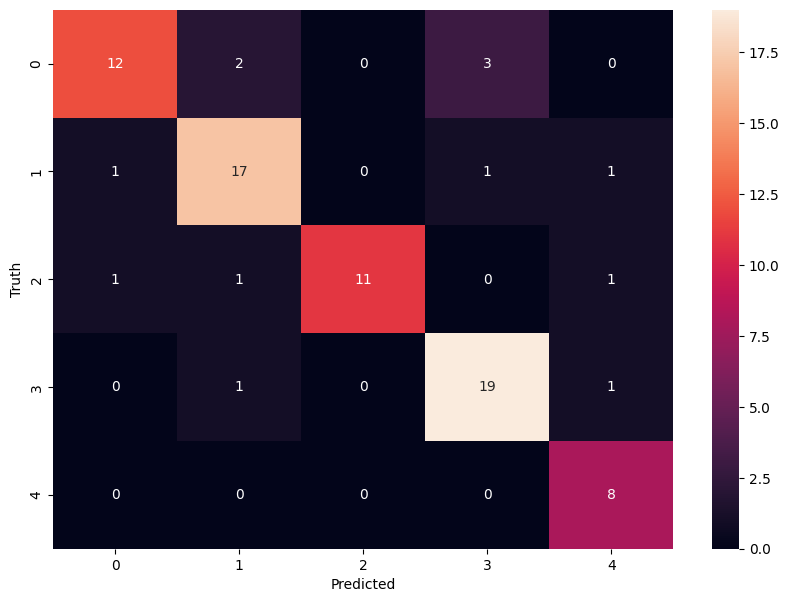

In [ ]:
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
joblib.dump(pipe, '/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/model.pkl')

['/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/model.pkl']

In [ ]:
with open('/content/drive/MyDrive/Colab Folders/Celebrity Recognition AI/class_dictionary.json', 'w') as f:
  f.write(json.dumps(class_dict))